# Figure 10: Scalability analysis on large-scale FLP problems.

This reproduction takes about <span style="color:red;">1.5 hours</span> on CPU.

In [1]:
import os
import time
import csv
import signal
import itertools
import random
import numpy as np
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, TimeoutError

from rasengan.problems.facility_location_problem import generate_flp
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import (
    ChocoSolver, QtoSolver, RasenganSolver, RasenganSegmentedSolver, 
    FakeQuebecProvider, DdsimProvider, NoisyDdsimProvider
)

np.random.seed(0xdb)
random.seed(0x7f)

## Problem Configuration

To reduce reproduction time:  
In Figures (a) and (b), we test <span style="color:red;">22</span> problem sizes (compared to <span style="color:red;">36</span> in the original paper).  
In Figures (c) and (d), we test up to <span style="color:red;">28</span>-bit (compared to <span style="color:red;">78</span> and <span style="color:red;">45</span>-bit respectively), and use a higher error rate.



In [2]:
# for fig (a) and (b)
m, n = 7, 7
num_cases_1 = 1
scale_list = [(i, j) for i in range(1, m + 1) for j in range(2, n + 1)][:22]
a, b = generate_flp(num_cases_1, scale_list, 1, 20)

# for fig (c) and (d)
num_cases_2 = 10
flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases_2, [(1, 2), (2, 2), (2, 3), (3, 2), (3, 3), (3, 4), (4, 3)], 1, 100)

## Evaluation of the Number of Segments and Circuit Depth

In [3]:
csv_path = "segments_and_depth.csv"
num_processes_cpu = os.cpu_count()
num_processes = max(1, num_processes_cpu // 4)

metrics_lst = ['depth', 'num_params']

with open(f'{csv_path}', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["m", "n", "variables"] + metrics_lst + ['depth_2', 'num_params_2'])

def process_layer(i):
    scale = scale_list[i]
    prb_model = a[i][0]
    num_vars = b[i][0][1]

    prb_model.set_penalty_lambda(200)

    opt = CobylaOptimizer(max_iter=50)
    provider = FakeQuebecProvider(transpile_mode=1)

    solver_1 = RasenganSolver(
        prb_model=prb_model,
        optimizer=opt,
        provider=provider,
        num_layers=5,
        shots=1024,
        opt_mode=[0, 0]
    )
    solver_2 = QtoSolver(
        prb_model=prb_model,
        optimizer=opt,
        provider=provider,
        num_layers=5,
        shots=1024,
    )

    metrics_1 = solver_1.circuit_analyze(metrics_lst)
    metrics_2 = solver_2.circuit_analyze(metrics_lst)

    return [scale[0], scale[1], num_vars] + metrics_1 + metrics_2

futures = []
with ProcessPoolExecutor(max_workers=num_processes) as executor:
    for i in range(len(scale_list)):
        futures.append(executor.submit(process_layer, i))

    for future in tqdm(futures, desc="Evaluating #segments and depth"):
        result = future.result()
        with open(f'{csv_path}', mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(result)

print(f'Data has been written to {csv_path}')


Evaluating #segments and depth: 100%|██████████| 22/22 [15:56<00:00, 43.48s/it] 


Data has been written to segments_and_depth.csv


## Evaluation on Larger-Scale Problems: Algorithmic Perspective

In [ ]:
large_evaluation_csv_path = "large_evaluation.csv"
problems_pkg = list(
    itertools.chain(
        enumerate(flp_problems_pkg),
    )
)
solvers = [ChocoSolver, RasenganSolver]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method'] + evaluation_metrics


def process_layer(prb, num_layers, solver):
    opt = CobylaOptimizer(max_iter=500)
    aer = DdsimProvider()
    prb.set_penalty_lambda(400)
    used_solver = solver(
        prb_model = prb,
        optimizer = opt,
        provider = aer,
        num_layers = num_layers,
        shots = 1024,
    )
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]

if __name__ == '__main__':
    print("Evaluating ARG on large-scale problems:")
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 3 # Set timeout duration
    num_complete = 0
    # print(evaluate_csv_path)
    with open(f'{large_evaluation_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    num_processes = num_processes_cpu // 4
    # pkid-pbid: 问题包序-包内序号
    
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for solver in solvers:

            solver_name = solver.__name__
            with ProcessPoolExecutor(max_workers=num_processes) as executor:
                futures = []
                layer = 5

                for pbid, prb in enumerate(problems):
                    future = executor.submit(process_layer, prb, layer, solver)
                    futures.append((future, prb, pkid, pbid, layer, solver_name))

                start_time = time.perf_counter()
                for future, prb, pkid, pbid, layer, solver in tqdm(futures, desc=f"problem_{pkid} using {solver_name}"):
                    current_time = time.perf_counter()
                    remaining_time = max(set_timeout - (current_time - start_time), 0)
                    diff = []
                    try:
                        metrics = future.result(timeout=remaining_time)
                        diff.extend(metrics)
                        # print(f"Task for problem {pkid}-{pbid} L={layer} {solver} executed successfully.")
                    except MemoryError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {solver} encountered a MemoryError.")
                        for dict_term in evaluation_metrics:
                            diff.append('memory_error')
                    except TimeoutError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {solver} timed out.")
                        for dict_term in evaluation_metrics:
                            diff.append('timeout')
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    finally:
                        row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), solver] + diff
                        with open(f'{large_evaluation_csv_path}', mode='a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(row)  # Write row immediately
                        num_complete += 1
                        if num_complete == len(futures):
                            # print(f'problem_pkg_{pkid} has finished')
                            for process in executor._processes.values():
                                os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {large_evaluation_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating ARG on large-scale problems:


problem_6 using RasenganSolver: 100%|██████████| 10/10 [04:04<00:00, 24.50s/it]

Data has been written to large_evaluation.csv
Time elapsed: 1394.74s


## Evaluation on Larger-Scale Problems: Noisy Environment

In [5]:
num_cases_2 = 5

flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases_2, [(1, 2), (2, 2), (2, 3), (3, 2), (3, 3), (3, 4), (4, 3)], 1, 100)

noisy_evaluation_csv_path = "noisy_evaluation.csv"
problems_pkg = list(
    itertools.chain(
        enumerate(flp_problems_pkg),
    )
)
solvers = [RasenganSegmentedSolver]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method'] + evaluation_metrics


def process_layer(prb, num_layers, solver):
    opt = CobylaOptimizer(max_iter=500)
    aer = NoisyDdsimProvider()
    prb.set_penalty_lambda(400)
    used_solver = solver(
        prb_model = prb,
        optimizer = opt,
        provider = aer,
        num_layers = num_layers,
        shots = 1024,
        num_segments = 10,
    )
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]

if __name__ == '__main__':
    print("Evaluating ARG under noise:")
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 3 # Set timeout duration
    num_complete = 0
    # print(evaluate_csv_path)
    with open(f'{noisy_evaluation_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    num_processes = num_processes_cpu // 4
    # pkid-pbid: 问题包序-包内序号
    
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for solver in solvers:

            solver_name = solver.__name__
            with ProcessPoolExecutor(max_workers=num_processes) as executor:
                futures = []
                layer = 5

                for pbid, prb in enumerate(problems):
                    future = executor.submit(process_layer, prb, layer, solver)
                    futures.append((future, prb, pkid, pbid, layer, solver_name))

                start_time = time.perf_counter()
                for future, prb, pkid, pbid, layer, solver in tqdm(futures, desc=f"problem_{pkid} using {solver_name}"):
                    current_time = time.perf_counter()
                    remaining_time = max(set_timeout - (current_time - start_time), 0)
                    diff = []
                    try:
                        metrics = future.result(timeout=remaining_time)
                        diff.extend(metrics)
                        # print(f"Task for problem {pkid}-{pbid} L={layer} {solver} executed successfully.")
                    except MemoryError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {solver} encountered a MemoryError.")
                        for dict_term in evaluation_metrics:
                            diff.append('memory_error')
                    except TimeoutError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {solver} timed out.")
                        for dict_term in evaluation_metrics:
                            diff.append('timeout')
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    finally:
                        row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), solver] + diff
                        with open(f'{noisy_evaluation_csv_path}', mode='a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(row)  # Write row immediately
                        num_complete += 1
                        if num_complete == len(futures):
                            # print(f'problem_pkg_{pkid} has finished')
                            for process in executor._processes.values():
                                os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {noisy_evaluation_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating ARG under noise:


problem_6 using RasenganSegmentedSolver: 100%|██████████| 5/5 [10:16<00:00, 123.37s/it]


Data has been written to noisy_evaluation.csv
Time elapsed: 3331.03s


## Load Results

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv('segments_and_depth.csv')
df_sorted = df.sort_values(by='variables')

def preprocess_df(filepath, methods):
    df = pd.read_csv(filepath)
    df = df.drop(columns=['pbid'])
    df = df[df['ARG'] <= 100000]
    grouped = df.groupby(['variables', 'method'], as_index=False).agg({
        'iteration_count': 'mean',
        'classcial': 'mean',
        'run_times': 'mean',
        'ARG': 'mean',
        'in_constraints_probs': 'mean',
        'best_solution_probs': 'mean',
    })
    values = ["variables", "ARG", 'best_solution_probs', 'classcial', 'in_constraints_probs', 'run_times', 'iteration_count']
    pivot = grouped.pivot(index='variables', columns='method', values=values)
    pivot = pivot.reindex(columns=pd.MultiIndex.from_product([values, methods]))
    return pivot

pivot_df_1 = preprocess_df('large_evaluation.csv', methods=['ChocoSolver', 'RasenganSolver'])
pivot_df_2 = preprocess_df('noisy_evaluation.csv', methods=['RasenganSegmentedSolver'])

## Plot Results

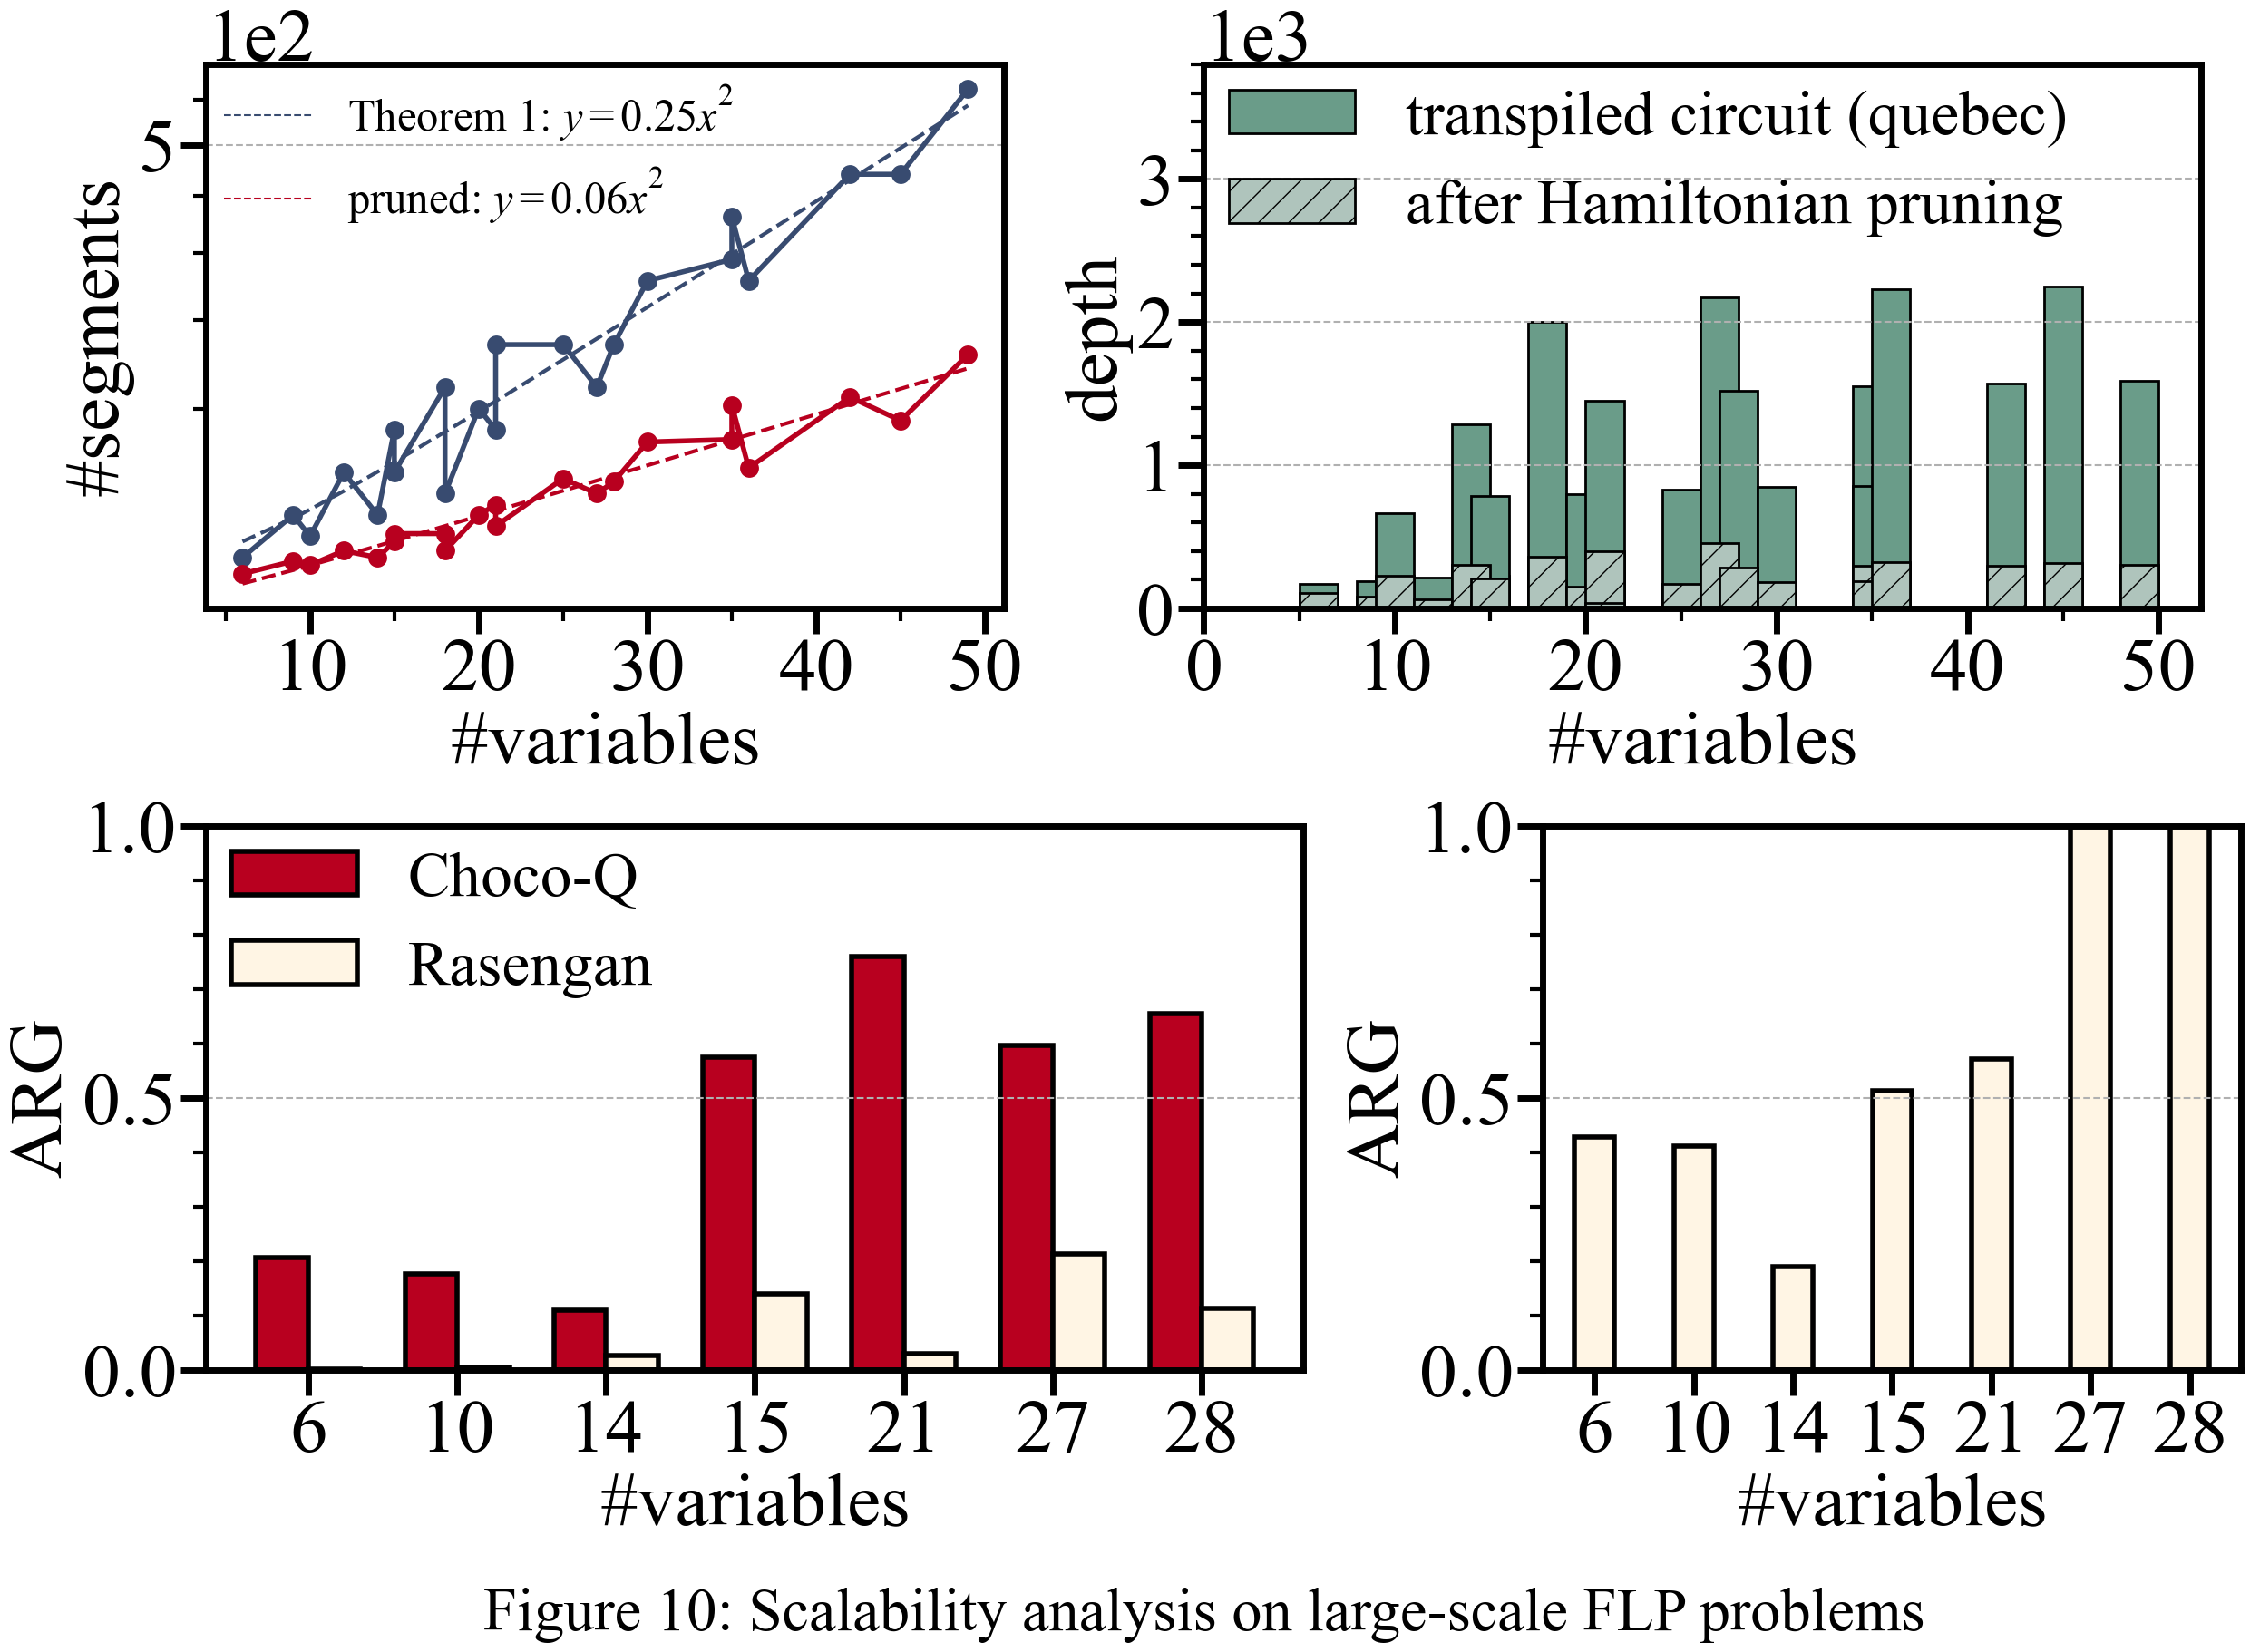

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 35,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

fig = plt.figure(figsize=(22, 12))

ax1 = plt.axes([0, 0.7, 0.4, 0.5])
ax2 = plt.axes([0.5, 0.7, 0.5, 0.5])
ax3 = plt.axes([0, 0, 0.55, 0.5])
ax4 = plt.axes([0.67, 0, 0.35, 0.5])

ax1.plot(df_sorted['variables'], df_sorted['num_params'], marker='o', linestyle='-', 
         color='#384B70', linewidth=4, markersize=15, markeredgewidth=0, markerfacecolor='#384B70')
ax1.plot(df_sorted['variables'], df_sorted['num_params_2'], marker='o', linestyle='-', 
         color='#B8001F', linewidth=4, markersize=15, markeredgewidth=0, markerfacecolor='#B8001F')

ax1.set_xlabel('#variables')
ax1.set_ylabel('#segments')
ax1.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax1.set_yscale('function', functions=(lambda x: np.sqrt(x), lambda x: x**2))
ax1.set_yticks(np.arange(0, 2600, 500))
ax1.set_yticks(np.arange(0, 2600, 100), minor=True)
ax1.set_xticks(np.arange(0, 51, 10))
ax1.set_xticks(np.arange(0, 51, 5), minor=True)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

def plot_fit_line(x, y, color, ax, str):
    coef = np.polyfit(x, y, 2)
    poly = np.poly1d(coef)
    ax.plot(x, poly(x), color=color, linestyle='--', linewidth=3)
    a, b, c = coef
    eq_str = f"{str}: $y = {a:.2f}x^2$"
    ax.plot([], [], linestyle='--', color=color, label=eq_str)

plot_fit_line(df_sorted['variables'], df_sorted['num_params'], '#384B70', ax1, "Theorem 1")
plot_fit_line(df_sorted['variables'], df_sorted['num_params_2'], '#B8001F', ax1, "pruned")
ax1.legend(
    loc='upper left', ncol=1, frameon=False,
    bbox_to_anchor=(0, 1), mode="expand", borderaxespad=0,
    fontsize=35
)


ratio_1 = df_sorted['depth'] / df_sorted['num_params']
ratio_2 = df_sorted['depth_2'] / df_sorted['num_params']

ax2.bar(df_sorted['variables'], ratio_1, width=2, color='#6A9C89', edgecolor='black', linewidth=2, label="transpiled circuit (quebec)")
ax2.bar(df_sorted['variables'], ratio_2, width=2, color='#afc4bc', hatch='/', edgecolor='black', linewidth=2, label="after Hamiltonian pruning")
ax2.legend(
    loc='upper left', ncol=1, frameon=False,
    bbox_to_anchor=(0, 1), mode="expand", borderaxespad=0,
    fontsize=50
)

ax2.set_xlabel('#variables')
ax2.set_ylabel('depth')
ax2.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax2.set_yticks(np.arange(0, 4000, 1000))
ax2.set_yticks(np.arange(0, 4000, 200), minor=True)
ax2.set_xticks(np.arange(0, 51, 10))
ax2.set_xticks(np.arange(0, 51, 5), minor=True)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# 

colors = ['#B8001F', '#FFF5E4', '#FFF']

arg_data = pivot_df_1['ARG']
bar_width = 0.35
pkid_values = arg_data.index.unique()
index = np.arange(len(pkid_values))

label_list = ["Choco-Q", "Rasengan"]
for idx, method in enumerate(arg_data.columns):
    ax3.bar(index + idx * bar_width, arg_data[method].values, bar_width,
            label=label_list[idx], color=colors[idx % len(colors)], edgecolor="black", linewidth=4)

ax3.legend(
    loc='upper left', ncol=1, frameon=False,
    bbox_to_anchor=(0, 1), mode="expand", borderaxespad=0,
    fontsize=50
)
ax3.set_xlabel('#variables', fontsize=60)
ax3.set_ylabel('ARG', fontsize=60)
ax3.set_xticks(index + bar_width * (len(arg_data.columns) / 2 - 0.5))
ax3.set_xticklabels(pkid_values)
ax3.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax3.set_yticks([i / 10 for i in range(0, 11, 5)])
ax3.set_yticks([i / 10 for i in range(0, 11, 1)], minor=True)

arg_data_2 = pivot_df_2['ARG']
bar_width = 0.4
pkid_values_2 = arg_data_2.index.unique()
index_2 = np.arange(len(pkid_values_2))

for idx, method in enumerate(arg_data_2.columns):
    ax4.bar(index_2 + idx * bar_width / 2, arg_data_2[method].values, bar_width,
            label=method, color=colors[1], edgecolor="black", linewidth=4)

ax4.set_xlabel('#variables', fontsize=60)
ax4.set_ylabel('ARG', fontsize=60)
ax4.set_xticks(index_2)
ax4.set_xticklabels(pkid_values_2)
ax4.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax4.set_ylim(0, 1)
ax4.set_yticks([i / 10 for i in range(0, 11, 5)])
ax4.set_yticks([i / 10 for i in range(0, 11, 1)], minor=True)

title = "Figure 10: Scalability analysis on large-scale FLP problems"
plt.suptitle(title, y=-0.2, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()